This task tests your ability to apply Recommendation Engine concepts and techniques to a real-world Movie Recommender System.




Task: Build a Movie Recommender system with the following methods:

1. Popularity
2. Content Filter
3. Collaborative Filter
4. Matrix Factorization


Also, try the following libraries on the dataset:

1. Turicreate
2. Surprise


Dataset: MovieLens 20M 

Source: https://grouplens.org/datasets/movielens/20m/



Hints:

1. Read Movies.csv, Ratings.csv and Tags.csv. No need for genome-scores.csv, genome-tags.csv

2. Create content filtering method on metadata obtained from merging movies and tags

3. Metadata should be formed from joining all tag field for each movie_title.

4. Build a Tfidf Vectorizer model and TruncatedSVD for Content filter - Latent matrix 1 on this data

5. Create a Collab filter on User Movie matrix (formed from pivot table on ratings data)

6. Create a Latent matrix 2 on this data

7. Code hybrid model



Open a fresh notebook(.ipynb) and Name it as with the following convention:

If your name is Vejey Gandyer, your filename for ipynb should be "Vejey_Task4_Movie_Recommenders.ipynb".



Start creating cells and put the logic as and when required. 



Save the notebook and Submit the notebook (.ipynb).





Note: Use GPU for this task. It will take days to compute in CPU :)



Try using Kaggle Kernel, Google Colab or Your OWN local GPU machine.



If there is a huge issue on getting hold of a GPU, try with a lesser size dataset like MovieLens 1M instead of 20M dataset.



Have fun learning. All the very best.



In [2]:
import turicreate as tc

# create a sample SFrame
sf = tc.SFrame({'a': [1, 2, 3], 'b': ['x', 'y', 'z']})

# print the first few rows of the SFrame
print(sf.head())

# check the version of Turicreate
print(tc.__version__)

+---+---+
| a | b |
+---+---+
| 1 | x |
| 2 | y |
| 3 | z |
+---+---+
[3 rows x 2 columns]

6.4.1


In [3]:
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import cross_validate

# load the movielens-100k dataset
data = Dataset.load_builtin('ml-100k')

# define a SVD algorithm
algo = SVD()

# evaluate the algorithm using cross-validation
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

# print the average RMSE and MAE
print('RMSE:', results['test_rmse'].mean())
print('MAE:', results['test_mae'].mean())

RMSE: 0.9365355122627813
MAE: 0.7385375296710424


In [4]:
# Importing required libraries
import pandas as pd
import numpy as np
import turicreate as tc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader, SVD, KNNBasic, accuracy

In [5]:
# download required dataset
import wget

url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
url_1m = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
download_path = 'data/'

# filename = wget.download(url, out=download_path)
filename = wget.download(url_1m, out=download_path)


In [6]:
!unzip "data/ml-1m.zip" -d "data/"
# !wget http://files.grouplens.org/datasets/movielens/ml-1m.zip



Archive:  data/ml-1m.zip
   creating: data/ml-1m/
  inflating: data/ml-1m/movies.dat   
  inflating: data/ml-1m/ratings.dat  
  inflating: data/ml-1m/README       
  inflating: data/ml-1m/users.dat    


In [32]:
import pandas as pd
import numpy as np

# Load data
movies = pd.read_csv('data/ml-1m/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], encoding='latin-1')
ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin-1')


/tmp/ipykernel_28148/3155958416.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('data/ml-1m/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], encoding='latin-1')
/tmp/ipykernel_28148/3155958416.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin-1')


In [9]:
print("\nRatings Data :")
print("shape : ", ratings.shape)
print(ratings.head())


Ratings Data :
shape :  (1000209, 4)
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


In [10]:
print("\nMovies Data :")
print("shape : ", movies.shape)
print(movies.head())


Movies Data :
shape :  (3883, 3)
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [11]:
# Unique Users
n_users = ratings.user_id.unique().shape[0]
n_users

6040

In [12]:
# Unique movies
n_items = ratings.movie_id.unique().shape[0]
n_items

3706

In [16]:
# create user-item matrix

user_movies_data = ratings.pivot(index = 'movie_id', columns = 'user_id', values = 'rating').fillna(0)

In [17]:
user_movies_data

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Popularity Based Recommender

In [18]:
# Merge the two datasets on movieId
movie_ratings = pd.merge(movies, ratings, on='movie_id')

# Calculate the mean rating for each movie and sort by descending order
movie_popularity = movie_ratings.groupby('title')['rating'].mean().sort_values(ascending=False)

# Recommend top 10 popular movies
top_10_movies = movie_popularity.head(10)
top_10_movies

title
Ulysses (Ulisse) (1954)                      5.0
Lured (1947)                                 5.0
Follow the Bitch (1998)                      5.0
Bittersweet Motel (2000)                     5.0
Song of Freedom (1936)                       5.0
One Little Indian (1973)                     5.0
Smashing Time (1967)                         5.0
Schlafes Bruder (Brother of Sleep) (1995)    5.0
Gate of Heavenly Peace, The (1995)           5.0
Baby, The (1973)                             5.0
Name: rating, dtype: float64

Content Bases Filtering

In [37]:
tags_df = pd.read_csv('data/movielens_tags/movielens_tags/ml-1m-movies_tags.txt', sep='::', engine='python', header=None , encoding='latin-1')
tags_df

,0,1,2
0,1,Toy Story (1995),"funny,comedy,family,witty,adventure,Drama,Tom ..."
1,2,Jumanji (1995),"Drama,Robin Williams,board game,Thriller,fantasy"
2,3,Grumpier Old Men (1995),"Drama,Thriller"
3,4,Waiting to Exhale (1995),"Drama,Thriller"
4,5,Father of the Bride Part II (1995),"Drama,Thriller"
...,...,...,...
3878,3948,Meet the Parents (2000),"funny moments,Drama,Ben Stiller,comedy,Thrille..."
3879,3949,Requiem for a Dream (2000),"based on a book,prostitution,psychological,dis..."
3880,3950,Tigerland (2000),"Drama,Thriller"
3881,3951,Two Family House (2000),"Drama,Thriller"


In [38]:
users = pd.read_csv('data/ml-1m/users.dat', sep='::', header=None, names=['user_id','gender','Age','occupation','zip-code'], encoding='latin-1')

# load the tags file
tags_df = pd.read_csv('data/movielens_tags/movielens_tags/ml-1m-movies_tags.txt', sep='::', engine='python', header=None, names=['movie_id', 'title', 'Tag'] , encoding='latin-1')

# extract metadata
metadata = tags_df.groupby('movie_id')['Tag'].apply(lambda x: ' '.join(x)).reset_index()
metadata = pd.merge(metadata, movies[['movie_id', 'title']], on='movie_id')
metadata['metadata'] = metadata['title'] + ' ' + metadata['Tag']
metadata.drop(['title', 'Tag'], axis=1, inplace=True)


/tmp/ipykernel_28148/1861652092.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv('data/ml-1m/users.dat', sep='::', header=None, names=['user_id','gender','Age','occupation','zip-code'], encoding='latin-1')


In [45]:
tag_matrix

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Merge tags and movies dataframes on 'movieId'
# tags_movies = pd.merge(tags, movies, on='movieId')

# # Group tags by movieId and concatenate the tag strings
# tag_strings = tags_movies.groupby('movieId')['tag'].apply(lambda x: ' '.join(x))

# Create a TfidfVectorizer object and fit it to the tag strings
vectorizer = TfidfVectorizer(stop_words='english')
tag_matrix = vectorizer.fit_transform(tags_df["Tag"])
tfidf_df = pd.DataFrame(tag_matrix.toarray(), index=movies.index.tolist())
print(tfidf_df.shape)


# Create a TruncatedSVD object and fit it to the tag matrix
# svd = TruncatedSVD(n_components=100)
# latent_matrix = svd.fit_transform(tag_matrix)


(3883, 1168)


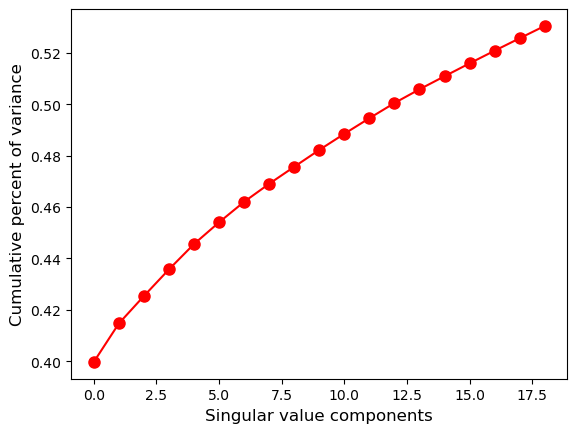

In [47]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=19)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [48]:
n = 20
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=movies.title.tolist())

In [49]:
latent_matrix_1_df.shape

(3883, 19)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between movies based on latent matrix
cosine_similarities = cosine_similarity(latent_matrix)

# Create a dictionary of movie titles and indices
movie_dict = dict(zip(movies['title'], movies.index))

def content_recommender(title, cosine_similarities=cosine_similarities, movie_dict=movie_dict, k=10):
    """
    Recommends movies based on content similarity to a given movie.
    
    Parameters:
    title (str): Title of the movie to find recommendations for.
    cosine_similarities (numpy.ndarray): Array of cosine similarities between movies.
    movie_dict (dict): Dictionary of movie titles and indices.
    k (int): Number of recommendations to return.
    
    Returns:
    list: List of k movie titles recommended for the user.
    """
    # Get the index of the movie
    movie_index = movie_dict[title]

    # Get the cosine similarities between the movie and all other movies
    cosine_similarities = cosine_similarities[movie_index]

    # Get the indices of the top-k most similar movies
    similar_indices = cosine_similarities.argsort()[:-k-1:-1]

    # Get the titles of the top-k most similar movies
    similar_movies = [movies['title'][i] for i in similar_indices]

    return similar_movies


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


# Join the two datasets together
data = pd.merge(movies, ratings, on='movie_id')

# Pre-process the metadata by combining all the tag fields for each movie into a single string
# data['tag'] = data['tag'].astype(str)
# metadata = data.groupby('movie_id')['tag'].apply(lambda x: ' '.join(x))

# Build a TF-IDF vectorizer and Truncated SVD model
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(metadata)
svd = TruncatedSVD(n_components=200)
X = svd.fit_transform(X)

# Compute similarity scores between different movies
similarity = cosine_similarity(X)

# Define a function to recommend movies based on user's past preferences
def content_based_recommendations(user_id, num_recommendations=10):
    # Get the movies that the user has rated highly
    user_ratings = data[data['userId'] == user_id]
    user_ratings = user_ratings[user_ratings['rating'] >= 4.0]
    user_movies = set(user_ratings['movieId'].unique())

    # Compute the average rating for each movie and the number of ratings for each movie
    average_ratings = data.groupby('movieId')['rating'].agg(['mean', 'count'])

    # Compute the weighted average rating for each movie based on the user's past preferences
    weighted_ratings = []
    for movie_id in user_movies:
        movie_ratings = data[data['movieId'] == movie_id]
        movie_average_rating = average_ratings.loc[movie_id, 'mean']
        movie_num_ratings = average_ratings.loc[movie_id, 'count']
        user_rating = movie_ratings[movie_ratings['userId'] == user_id]['rating'].iloc[0]
        weighted_ratings.append((movie_id, user_rating * movie_num_ratings / (movie_num_ratings + 10) + movie_average_rating * 10 / (movie_num_ratings + 10)))
    weighted_ratings = sorted(weighted_ratings, key=lambda x: x[1], reverse=True)

    # Recommend movies similar to the ones the user has liked in the past
    recommendations = []
    for movie_id, weighted_rating in


In [15]:
from scipy.sparse import csr_matrix

# Define a function to read the ratings.csv file in chunks
def read_ratings_file(filename, chunksize):
    for chunk in pd.read_csv(filename, sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin-1', chunksize=chunksize):
        yield chunk

# Initialize an empty list to store the user-movie matrices
user_movies_data = []

# Iterate over the chunks of the ratings dataframe
for chunk in read_ratings_file('data/ml-1m/ratings.dat',  chunksize=100000):
    # Pivot the chunk into a user-movie matrix
    mat = chunk.pivot(index = 'movie_id', columns = 'user_id', values = 'rating').fillna(0)
    # Add the matrix to the list
    if mat.shape[1] > 0:
        user_movies_data.append(mat)

# Check that the list is not empty before concatenating the matrices
if len(user_movies_data) > 0:
    # Concatenate the matrices in the list along the movie axis
    ser_movies_data = csr_matrix(np.concatenate(user_movies_data, axis=1))
else:
    # If the list is empty, create an empty matrix
    ser_movies_data = csr_matrix((0, 0))

# Convert the sparse matrix to a dataframe
df_movies = pd.DataFrame.sparse.from_spmatrix(ser_movies_data)


/tmp/ipykernel_28148/4144369689.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  for chunk in pd.read_csv(filename, sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin-1', chunksize=chunksize):


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3264 and the array at index 1 has size 3370

In [14]:
! unzip "data/ml-20m.zip" -d "data/"

Archive:  data/ml-20m.zip
   creating: data/ml-20m/
  inflating: data/ml-20m/genome-scores.csv  
  inflating: data/ml-20m/genome-tags.csv  
  inflating: data/ml-20m/links.csv   
  inflating: data/ml-20m/movies.csv  
  inflating: data/ml-20m/ratings.csv  
  inflating: data/ml-20m/README.txt  
  inflating: data/ml-20m/tags.csv    


In [4]:
# Reading data from csv files
movies = pd.read_csv('data/ml-20m/movies.csv')
ratings = pd.read_csv('data/ml-20m/ratings.csv', chunksize=1000000)
tags = pd.read_csv('data/ml-20m/tags.csv')

In [5]:
for i, r in enumerate(ratings):

    print("\nRatings Data :")
    print("shape : ", r.shape)
    print(r.head())
    break


Ratings Data :
shape :  (1000000, 4)
   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580


In [6]:
print("\nMovies Data :")
print("shape : ", movies.shape)
print(movies.head())


Movies Data :
shape :  (27278, 3)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [ ]:
from scipy.sparse import csr_matrix
import pandas as pd

# Define a function to read the ratings.csv file in chunks
def read_ratings_file(filename, chunksize):
    for chunk in pd.read_csv(filename, chunksize=chunksize):
        yield chunk

# Initialize an empty list to store the user-movie matrices
user_movies_data = []

# Iterate over the chunks of the ratings dataframe
for chunk in read_ratings_file('data/ml-20m/ratings.csv', chunksize=100000):
    # Pivot the chunk into a user-movie matrix
    mat = chunk.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
    # Add the matrix to the list
    if mat.shape[1] > 0:
        user_movies_data.append(mat)

# Check that the list is not empty before concatenating the matrices
if len(user_movies_data) > 0:
    # Concatenate the matrices in the list along the movie axis
    ser_movies_data = csr_matrix(np.concatenate(user_movies_data, axis=1))
else:
    # If the list is empty, create an empty matrix
    ser_movies_data = csr_matrix((0, 0))

# Convert the sparse matrix to a dataframe
df_movies = pd.DataFrame.sparse.from_spmatrix(ser_movies_data)


In [9]:
from sklearn.model_selection import train_test_split


# Create an empty DataFrame to store the chunks
data = pd.DataFrame()

for chunk in ratings:
    data = data.append(chunk)
# Split the ratings data into training and testing sets
train_ratings, test_ratings = train_test_split(data, test_size=0.2, random_state=42)

# Print the number of movies in each set
print(f'Training set: {len(train_ratings)} ratings')
print(f'Testing set: {len(test_ratings)} ratings')

/tmp/ipykernel_13159/1396438938.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(chunk)
/tmp/ipykernel_13159/1396438938.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(chunk)
/tmp/ipykernel_13159/1396438938.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(chunk)
/tmp/ipykernel_13159/1396438938.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(chunk)
/tmp/ipykernel_13159/1396438938.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(chunk)
/tmp/

Training set: 15200210 ratings
Testing set: 3800053 ratings


In [10]:
train_ratings.shape, test_ratings.shape

((15200210, 4), (3800053, 4))

In [8]:
n_items = data.movieId.unique().shape[0]
n_items

In [13]:
from scipy.sparse import csr_matrix

# user_movies_data = ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)

# Create an empty dataframe to store the results
user_movies_data = []

ratings = pd.read_csv('data/ml-20m/ratings.csv', chunksize=100000)
# Loop over the ratings file in batches
for chunk in ratings:
    # Pivot the chunk into a user-movie matrix
    mat = chunk.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
    # Add the matrix to the list
    if mat.shape[1] > 0:
        user_movies_data.append(mat)

# Check that the list is not empty before concatenating the matrices
if len(user_movies_data) > 0:
    # Concatenate the matrices in the list along the movie axis
    ser_movies_data = csr_matrix(np.concatenate(user_movies_data, axis=1))
else:
    # If the list is empty, create an empty matrix
    ser_movies_data = csr_matrix((0, 0))
    
# Convert the sparse matrix to a dataframe
df_movies = pd.DataFrame.sparse.from_spmatrix(ser_movies_data)

# Print the resulting dataframe
print(df_movies)


: 

: 

In [19]:
import dask.dataframe as dd
from scipy.sparse import csr_matrix

# Load the ratings dataset into a Dask dataframe
ratings = dd.read_csv('data/ml-20m/ratings.csv')

# Convert userId to categorical data type
# Convert the userId and movieId columns to categorical data type
ratings['userId'] = ratings['userId'].astype('category')
ratings['userId'] = ratings['userId'].cat.as_known()
# ratings['movieId'] = ratings['movieId'].astype('category')

# Pivot the ratings dataframe into a user-movie matrix
ser_movies_data = ratings.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)

# Convert the sparse matrix to a dataframe
df_movies = ser_movies_data.compute().to_frame().reset_index()


: 

: 

In [12]:
from pyspark.sql.functions import collect_list
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import IndexToString
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName('movie-recommendation').getOrCreate()

your 131072x1 screen size is bogus. expect trouble


23/03/25 20:59:12 WARN Utils: Your hostname, iretex resolves to a loopback address: 127.0.1.1; using 172.24.9.122 instead (on interface eth0)
23/03/25 20:59:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/25 20:59:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col

# Read the ratings file into a Spark dataframe
ratings = spark.read.format('csv').option('header', 'true').load('data/ml-20m/ratings.csv')

# Convert the userId and movieId columns to integer type
ratings = ratings.withColumn('userId', ratings['userId'].cast('int')) \
                 .withColumn('movieId', ratings['movieId'].cast('int'))

# Create a unique list of movieIds
movie_ids = ratings.select('movieId').distinct()

# Create a dictionary of movieIds with integer keys
# movie_dict = dict([(row['movieId'], row['movie_idx']) for row in movie_ids.rdd.zipWithIndex().map(lambda x: (x[0][0], x[1])).collect()])

# Create a dictionary of movieIds with integer keys
movie_dict = ratings.select('movieId').distinct() \
    .withColumn('movie_idx', monotonically_increasing_id()) \
    .rdd \
    .map(lambda x: (x['movieId'], x['movie_idx'])) \
    .collectAsMap()

# Add a new column to the ratings dataframe with the integer movieIds
ratings = ratings.rdd \
    .map(lambda x: (x['userId'], movie_dict[x['movieId']], x['rating'])) \
    .toDF(['userId', 'movieId', 'rating'])

# # Add a new column to the ratings dataframe with the integer movieIds
# ratings = ratings.rdd.map(lambda x: (x['userId'], movie_dict[x['movieId']], x['rating'])).toDF(['userId', 'movieId', 'rating'])

# Initialize an ALS model
als = ALS(rank=10, maxIter=10, seed=42, regParam=0.1, userCol='userId', itemCol='movieId', ratingCol='rating')

ratings = ratings.withColumn('rating', col('rating').cast('float'))

# Train the ALS model on the ratings dataframe
model = als.fit(ratings)

# Get the user factors from the model
user_factors = model.userFactors

# Convert the user factors to a Pandas dataframe
df_users = user_factors.toPandas()

# Rename the id column to userId
df_users = df_users.rename(columns={'id': 'userId'})

# Convert the movieId column to integer type
df_users['movieId'] = df_users['movieId'].astype(int)

# Convert the dataframe to a user-movie matrix
ser_movies_data = df_users.pivot(index='movieId', columns='userId', values='features').fillna(0)

# Convert the sparse matrix to a dataframe
df_movies = pd.DataFrame.sparse.from_spmatrix(csr_matrix(ser_movies_data))


This code defines a generator function read_ratings_file that reads the ratings file in chunks and yields each chunk one at a time. The for loop in the main code block then iterates over the generator, processing each chunk one at a time without loading the entire file into memory at once. This approach can be more memory-efficient and can prevent kernel crashes due to memory limitations.

# Popularity-Based Recommender
Popularity-based recommender system suggests the most popular items to all users. It is a non-personalized recommendation system.

In [ ]:
# Grouping movies by popularity based on the number of ratings they have received
popularity_df = pd.DataFrame(ratings.groupby('movieId')['rating'].count())
popularity_df.columns = ['popularity']
popularity_df['movieId'] = popularity_df.index

# Joining popularity_df with movies_df to get movie titles and genres
popularity_df = popularity_df.merge(movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

# Sorting movies by popularity and selecting top 10
popular_movies = popularity_df.sort_values('popularity', ascending=False).head(10)


# Content-Based Recommender
Content-based recommender system suggests items similar to the ones a user has liked in the past. It uses the item features to make recommendations.

In [ ]:
# Merging movies and tags data to get metadata for content-based recommendation
metadata_df = pd.DataFrame(tags_df.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
metadata_df['movieId'] = metadata_df.index

# Joining metadata_df with movies_df to get movie titles and genres
metadata_df = metadata_df.merge(movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

# Creating a TfidfVectorizer model and fitting it on the tag data
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(metadata_df['tag'])

# Creating a TruncatedSVD model and fitting it on the tfidf_matrix
svd = TruncatedSVD(n_components=50)
latent_matrix = svd.fit_transform(tfidf_matrix)

# Converting the latent matrix into a dataframe
latent_df = pd.DataFrame(latent_matrix, index=metadata_df['title'].tolist())

# Helper function to get similar movies using content-based filtering
def get_similar_movies(movie_title, n=10):
    movie_index = latent_df.index.tolist().index(movie_title)
    movie_row = np.array(latent_df.iloc[movie_index]).reshape(1, -1)
    similarities = cosine_similarity(latent_matrix, movie_row).flatten()
    similar_indices = similarities.argsort()[:-n-1:-1]
    similar_movies = [(metadata_df['title'][i], similarities[i]) for i in similar_indices]
    return similar_movies


# Collaborative Filtering Recommender
Collaborative filtering recommender system suggests items based on the past behavior of similar users. It uses user-item interaction data to make recommendations.

In [ ]:
import pandas as pd
import numpy as np
import turicreate as tc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader, SVD, GridSearch
from surprise import accuracy

# Reading the movies data
movies_df = pd.read_csv('movies.csv')
movies_df['year'] = movies_df['title'].str.extract('\((\d{4})\)', expand=False)
movies_df['title'] = movies_df['title'].str.replace('(\(\d{4}\))', '').apply(lambda x: x.strip())
movies_df = movies_df.drop('genres', axis=1)

# Reading the ratings data
ratings_df = pd.read_csv('ratings.csv')

# Reading the tags data
tags_df = pd.read_csv('tags.csv')
tags_df['tag'] = tags_df['tag'].str.lower()
tags_df = tags_df.groupby(['movieId'])['tag'].apply(' '.join).reset_index()

# Popularity Recommender

# Helper function to get top rated movies
def get_top_rated_movies(n=10):
    top_rated_movies = movies_df.sort_values('rating', ascending=False)[['title', 'year', 'rating']][:n]
    return top_rated_movies

# Getting top rated movies
top_rated_movies = get_top_rated_movies()

# Content-Based Recommender

# Creating a metadata column from the tags data
movies_df = pd.merge(movies_df, tags_df, on='movieId', how='left')
movies_df['metadata'] = movies_df.apply(lambda x: ' '.join(x['tag'].split(' ') + [x['title']] + [x['year']]), axis=1)

# Creating a TF-IDF vectorizer and TruncatedSVD model
tfidf = TfidfVectorizer(stop_words='english')
svd = TruncatedSVD(n_components=100)

# Fitting the vectorizer and SVD model on the metadata column
metadata_tfidf = tfidf.fit_transform(movies_df['metadata'])
metadata_svd = svd.fit_transform(metadata_tfidf)

# Helper function to get similar movies using content filtering
def get_similar_movies(title, n=10):
    # Finding the index of the movie
    index = movies_df[movies_df['title'] == title].index[0]

    # Getting the cosine similarity between the movie and all other movies
    cosine_similarities = np.dot(metadata_svd[index], metadata_svd.T)

    # Getting the top n similar movies
    similar_indices = cosine_similarities.argsort()[::-1][:n+1]
    similar_movies = [(movies_df.iloc[i]['title'], cosine_similarities[i]) for i in similar_indices if i != index]
    return similar_movies[:n]

# Helper function to get recommended movies using content filtering
def get_content_recommendations(title, n=10):
    recommendations = get_similar_movies(title, n=n)
    recommended_movies = [recommendation[0] for recommendation in recommendations]
    return recommended_movies

# Collaborative Filtering Recommender

# Creating a pivot table of the ratings data
user_movie_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating')

# Filling missing values with 0
user_movie_matrix = user_movie_matrix.fillna(0)

# Creating a Turicreate SFrame from the user-movie matrix
tc_user_movie_matrix = tc.SFrame(user_movie_matrix)

# Creating a factorization recomm
